# Lets Implement BERT for Word And Sentence Embeddings and do classification

## Import Section


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn as skl
import glob
import io
import os
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
#!pip install tensorflow_text
import tensorflow_text as text
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model



## Lets pull the dataset

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle dataset
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'shivamkushwaha/bbc-full-text-document-classification'
!unzip bbc-full-text-document-classification.zip -d dataset

## Text files to CSV

> Data has 5 subfolders which are actually the labels of the news. They are politics, sports, tech, entertainment and business news. Each of these subfolders contains several news in the form of .txt files.

> For easy use, I define following function to read all of these files along with their category and convert them to a single pandas CSV data frame.

In [3]:
dir_path = []
for dirname, _, filenames in os.walk('/content/dataset/bbc-fulltext (document classification)/bbc'):
    dir_path.append(dirname)

dir_path

['/content/dataset/bbc-fulltext (document classification)/bbc',
 '/content/dataset/bbc-fulltext (document classification)/bbc/business',
 '/content/dataset/bbc-fulltext (document classification)/bbc/politics',
 '/content/dataset/bbc-fulltext (document classification)/bbc/entertainment',
 '/content/dataset/bbc-fulltext (document classification)/bbc/tech',
 '/content/dataset/bbc-fulltext (document classification)/bbc/sport']

In [4]:
def text_to_pandasDF(path):
    df = pd.DataFrame(columns=['news', 'class'])
    txt = []
    label = []
    for dirpath in tqdm(path):
        text_files_path = sorted(glob.glob(os.path.join(dirpath, '*.txt')))
        for text_path in text_files_path:
            with io.open(text_path, 'r', encoding='utf-8', errors='ignore') as txt_file:
                txt.append(txt_file.read())
                label.append(dirpath.split('/')[-1])
    df['news'] = txt
    df['class'] = label
    txt, label = [], []
    
    return df

In [5]:
classification_dataframe = text_to_pandasDF(dir_path[1:])
classification_dataframe.head()

100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


,news,class
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


### Lets See how the classes are distributed

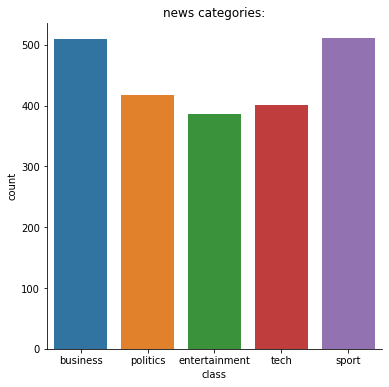

In [6]:
plt.figure(figsize=(6,6))
plt.title("news categories:")
sns.countplot(x=classification_dataframe["class"])
sns.despine(top=True, right=True, left=False, bottom=False)


## Data Preprocessing

In [7]:
X = classification_dataframe['news']
#label one_hot encoding
y = np.array(classification_dataframe['class'])
y = np.reshape(y, (-1,1))
y = OneHotEncoder().fit_transform(y).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train[0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

In [9]:
y_train[0]

array([0., 0., 0., 0., 1.])

### importing bert from tensorflow hub


In [10]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
model_preprocessing_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

preprocessor = hub.KerasLayer(model_preprocessing_url)
encoder = hub.KerasLayer(model_url)

### Model creation

In [11]:
#BERT Layers
input_layer = Input(shape=(), dtype=tf.string)
preprocess_layer = preprocessor(input_layer)
bert_output = encoder(preprocess_layer)

#Fully connected layers
z = Dropout(0.1)(bert_output['pooled_output'])
z = Dense(5, activation='softmax')(z)

model = Model(inputs=input_layer, outputs=z)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

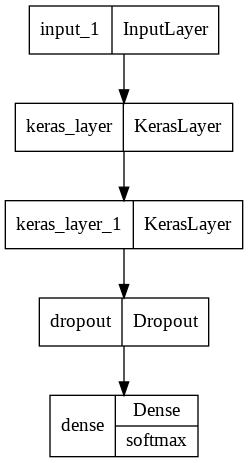

In [12]:
plot_model(model,show_layer_activations = True)

In [15]:
model_history = model.fit(x=X_train,y=y_train,batch_size=32,validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],epochs=20)

Epoch 1/10
45/45 [==============================] - 21s 476ms/step - loss: 0.6708 - accuracy: 0.8301 - val_loss: 0.5804 - val_accuracy: 0.8792
Epoch 2/10
45/45 [==============================] - 20s 453ms/step - loss: 0.6359 - accuracy: 0.8287 - val_loss: 0.5478 - val_accuracy: 0.9185
Epoch 3/10
45/45 [==============================] - 20s 449ms/step - loss: 0.6026 - accuracy: 0.8441 - val_loss: 0.5221 - val_accuracy: 0.9101
Epoch 4/10
45/45 [==============================] - 20s 449ms/step - loss: 0.5813 - accuracy: 0.8581 - val_loss: 0.5059 - val_accuracy: 0.9101
Epoch 5/10
45/45 [==============================] - 20s 449ms/step - loss: 0.5716 - accuracy: 0.8476 - val_loss: 0.4826 - val_accuracy: 0.9073
Epoch 6/10
45/45 [==============================] - 20s 449ms/step - loss: 0.5398 - accuracy: 0.8603 - val_loss: 0.4680 - val_accuracy: 0.9101


In [35]:
y_pred = model.predict(X_test)
y_prob =np.max(y_pred,axis = 1)
y_pred = np.argmax(y_pred,axis = 1)
y_test_check =  np.argmax(y_test,axis = 1)

14/14 [==============================] - 4s 336ms/step


accuracy score : 0.8831460674157303
f1 score : 0.8831460674157303
classification report : 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       115
           1       0.93      0.85      0.89        73
           2       0.80      0.81      0.81        75
           3       0.96      0.95      0.96       102
           4       0.89      0.89      0.89        80

    accuracy                           0.88       445
   macro avg       0.88      0.88      0.88       445
weighted avg       0.88      0.88      0.88       445

*********** confusion matrx ***********


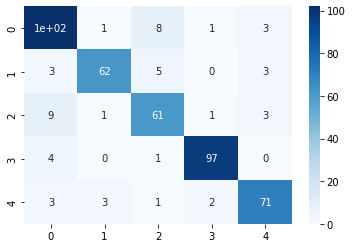

In [43]:
print("accuracy score :",accuracy_score(y_test_check,y_pred))
print("f1 score :",f1_score(y_test_check,y_pred,average ='micro'))
print('classification report : \n', classification_report(y_test_check,y_pred))
print('*********** confusion matrx ***********')
sns.heatmap(confusion_matrix(y_test_check,y_pred),annot = True, cmap = 'Blues')